In [1]:
import os
import nibabel as nib
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.glm.first_level import make_first_level_design_matrix, run_glm
from nilearn.glm.contrasts import compute_contrast

In [2]:
# Function to load brain and event data
def load_data(data_dir, brain_filename, event_filename):
    brain_file = os.path.join(data_dir, brain_filename)
    event_file = os.path.join(data_dir, event_filename)

    brain_img = nib.load(brain_file)
    brain_data = brain_img.get_fdata()
    print(f"Brain data shape: {brain_data.shape}")

    event_mat = sio.loadmat(event_file)['mldata'][0][0][0]

    return brain_data, event_mat

In [3]:
# Function to extract event-related information
def extract_event_info(event_mat):
    condition = event_mat[:]["Condition"]
    behave_codes = event_mat[:]["BehavioralCodes"]
    absolute_starttime = event_mat[:]["AbsoluteTrialStartTime"]
    return condition, behave_codes, absolute_starttime

In [4]:
# this function is used for the reward trial only
# Here we only model the reward type (exclude the cue) for the following reasons:
# - last week (08/11/24) we modeled (1) cue+stimulus (reward, airpuff, and idle), (2) stimulus only, and (3) cue only. We found that the model with cue+stimulus has similar result as the model with stimulus only between reward and airpuff
# - all data collected before 05/24/24 didn't document the airpuff and idle contidions well so we only have access to the reward condition
# - the cue+stimulus model will confuse between reward and airpuff because the cue is the same for both conditions, so we will only model the stimulus/reward condition

def create_design_matrix_reward_only(condition, behave_codes, absolute_starttime, fixed_duration=2):
    event_df = pd.DataFrame(columns=['onset', 'trial_type', 'duration', 'raw_onset'], index=range(len(behave_codes)))

    for i, (c, b, s) in enumerate(zip(condition, behave_codes, absolute_starttime)):
        cond = c[0][0][0] if isinstance(c, np.ndarray) and c.ndim >= 3 else c[0][0] if isinstance(c, np.ndarray) and c.ndim == 2 else c
        trial_start = s[0][0] if isinstance(s, np.ndarray) and s.ndim >= 2 else s

        if cond == 1:
            trial_type = b[0][0][1][4][0] 
            stimulus_onset = b[0][0][0][4] + trial_start if isinstance(b, np.ndarray) else trial_start
        else:
            trial_type = cond
            stimulus_onset = b[0][0][0][3] + trial_start if isinstance(b, np.ndarray) else trial_start

        event_df.at[i, 'raw_onset'] = stimulus_onset / 1000
        event_df.at[i, 'trial_type'] = str(trial_type)
        event_df.at[i, 'duration'] = fixed_duration

    event_df['onset'] = event_df['raw_onset'] - absolute_starttime[0][0] / 1000 if isinstance(absolute_starttime[0], np.ndarray) else absolute_starttime[0] / 1000

    return event_df

In [5]:
def create_design_matrix(behave_codes, absolute_starttime, fixed_duration=2):
    event_df = pd.DataFrame(columns=['onset', 'trial_type', 'duration', 'raw_onset'], index=range(len(behave_codes)))

    for i, (b, s) in enumerate(zip(behave_codes, absolute_starttime)):
        trial_start = s[0][0] if isinstance(s, np.ndarray) and s.ndim >= 2 else s
        if i == 0:
            trial_type = b[0][0][1][4][0]
            stimulus_onset = b[0][0][0][4] + trial_start
        else:
            trial_type = b[0][0][1][2][0]
            stimulus_onset = b[0][0][0][2] + trial_start
        event_df.at[i, 'raw_onset'] = stimulus_onset / 1000
        event_df.at[i, 'trial_type'] = str(trial_type)
        event_df.at[i, 'duration'] = fixed_duration

    event_df['onset'] = event_df['raw_onset'] - absolute_starttime[0][0] / 1000 if isinstance(absolute_starttime[0], np.ndarray) else absolute_starttime[0] / 1000

    return event_df

In [6]:
# Function to create GLM design matrix
def create_glm_design_matrix(brain_data, event_df, tr=1/2.5, hrf_model='glover', drift_model='polynomial', drift_order=3):
    n_tr = brain_data.shape[-1]
    frame_times = np.arange(n_tr) * tr

    X = make_first_level_design_matrix(
        frame_times=frame_times,
        events=event_df,
        drift_model=drift_model,
        drift_order=drift_order,
        hrf_model=hrf_model
    )

    return X

In [7]:
# Function to run GLM and compute contrasts
def run_glm_and_compute_contrasts(brain_data, X, contrast_conditions):
    Y = brain_data.reshape(-1, brain_data.shape[-1])
    labels, estimators = run_glm(Y.T, X.values)

    contrast_matrix = np.eye(X.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate(X.columns)])

    contrast_results = {}
    for contrast_id, contrast_value in contrast_conditions.items():
        contrast_vector = contrast_value if isinstance(contrast_value, np.ndarray) else basic_contrasts[contrast_value]
        contrast = compute_contrast(labels, estimators, contrast_vector, stat_type='t')
        contrast_results[contrast_id] = contrast.z_score()

    return contrast_results

In [8]:
# Function to plot contrasts
def plot_contrasts(contrast_results, shape=(128, 143), vmin=-15, vmax=15):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, (key, value) in enumerate(contrast_results.items()):
        sns.heatmap(value.reshape(*shape).T, ax=axes[i], cmap="bwr", vmin=vmin, vmax=vmax)
        axes[i].set_title(key)

    plt.tight_layout()
    plt.show()

In [9]:
# Main function to run the entire GLM analysis
def run_glm_analysis(data_dir, brain_filename, event_filename, contrast_conditions, vmin=-5, vmax=5, before0523=False):
    brain_data, event_mat = load_data(data_dir, brain_filename, event_filename)
    condition, behave_codes, absolute_starttime = extract_event_info(event_mat)
    if before0523:
        event_df = create_design_matrix_reward_only(condition, behave_codes, absolute_starttime)
    else:
        event_df = create_design_matrix(behave_codes, absolute_starttime)
    X = create_glm_design_matrix(brain_data, event_df)
    contrast_results = run_glm_and_compute_contrasts(brain_data, X, contrast_conditions)
    plot_contrasts(contrast_results, vmin=vmin, vmax=vmax)

## Grouper_0516

pixdim[1,2,3] should be positive; setting to abs of pixdim values
/Users/yibeichen/micromamba/envs/neuro/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: raw_onset
  warnings.warn(


Brain data shape: (128, 1, 143, 4500)


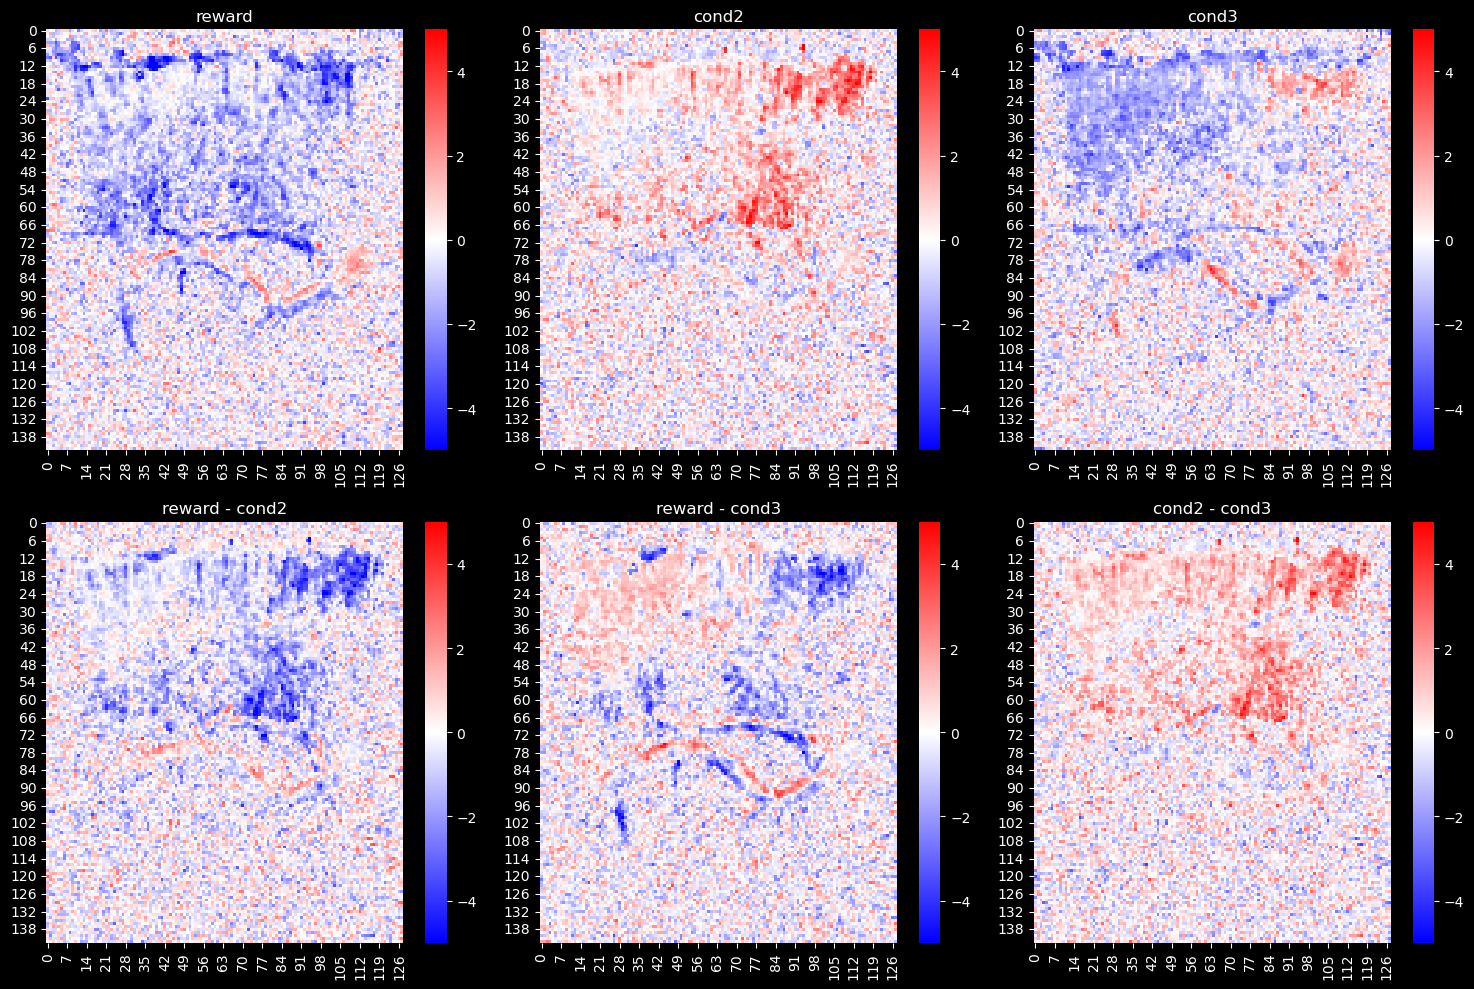

In [10]:
data_dir = '/Users/yibeichen/Desktop/fusi/task_data/Grouper_Audiocue_data/same_plane/Grouper_0516_1.5'
brain_filename = 'Grouper_audiocue_051624_2Dscan_1_fus2D.source.nii'
event_filename = 'mldata.mat'

contrast_conditions = {
    'reward': '5',
    'cond2': '2',
    'cond3': '3',
    'reward - cond2': np.array([-1, 0, 1, 0, 0, 0, 0]),
    'reward - cond3': np.array([0, -1, 1, 0, 0, 0, 0]),
    'cond2 - cond3': np.array([1, -1, 0, 0, 0, 0, 0]),
}

run_glm_analysis(data_dir, brain_filename, event_filename, contrast_conditions, before0523=True)


# Grouper_0521

pixdim[1,2,3] should be positive; setting to abs of pixdim values
/Users/yibeichen/micromamba/envs/neuro/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: raw_onset
  warnings.warn(


Brain data shape: (128, 1, 143, 9000)


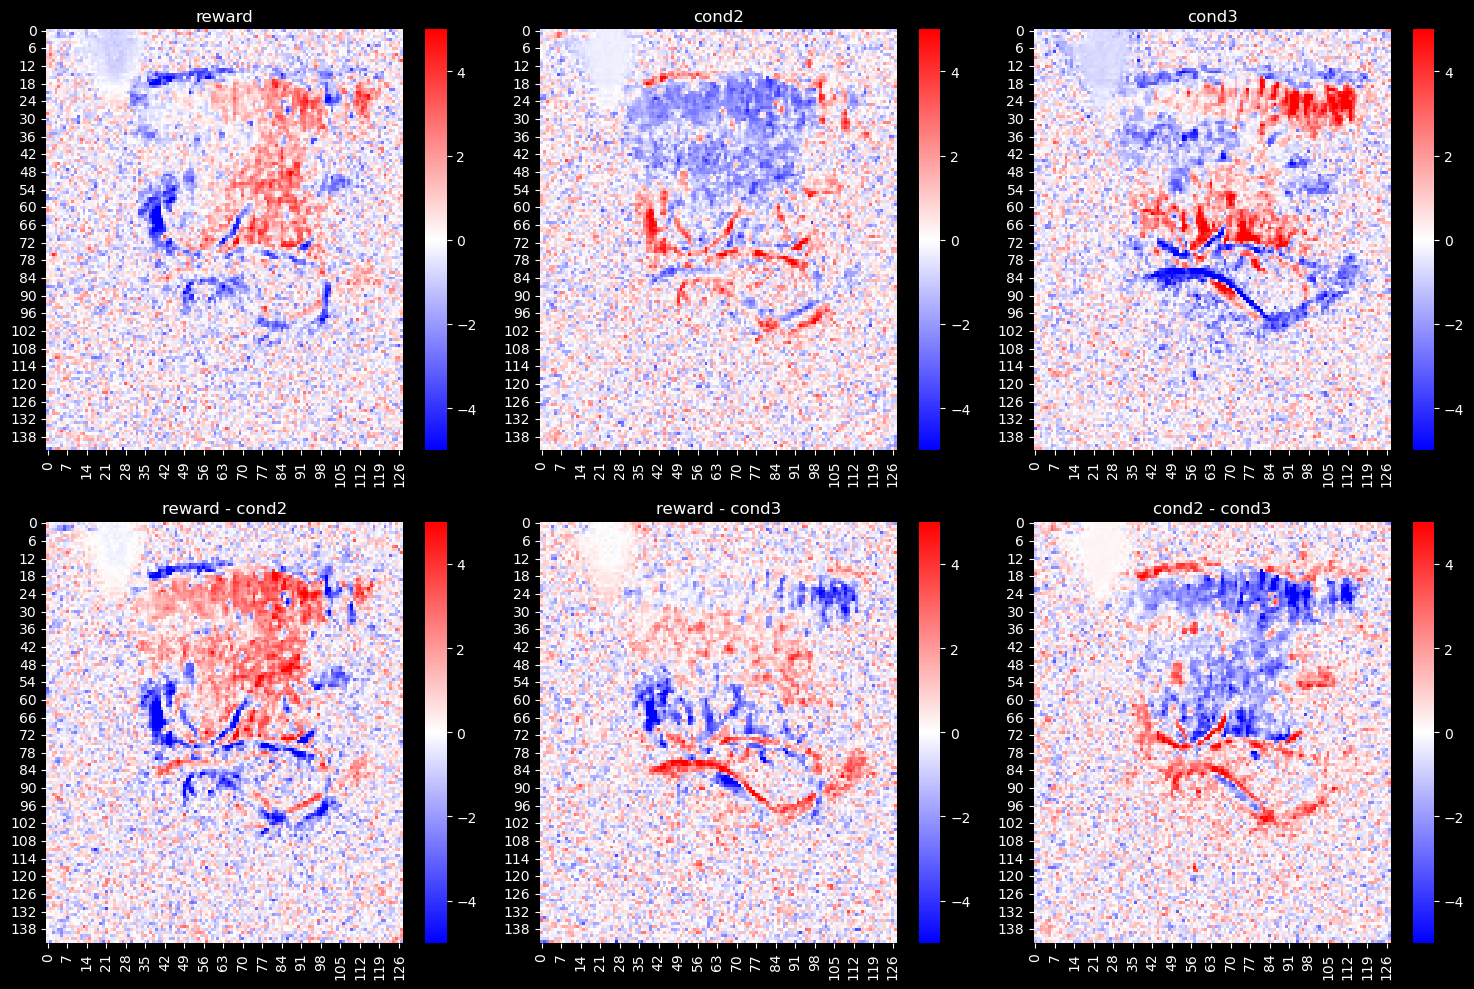

In [11]:
data_dir = '/Users/yibeichen/Desktop/fusi/task_data/Grouper_Audiocue_data/same_plane/Grouper_0521_1.5'
brain_filename = 'Grouper_audiocue_052124_fus2D.2Dscan_1_fus2D.source.nii'
event_filename = 'mldata.mat'

contrast_conditions = {
    'reward': '5',
    'cond2': '2',
    'cond3': '3',
    'reward - cond2': np.array([-1, 0, 1, 0, 0, 0, 0]),
    'reward - cond3': np.array([0, -1, 1, 0, 0, 0, 0]),
    'cond2 - cond3': np.array([1, -1, 0, 0, 0, 0, 0]),
}

run_glm_analysis(data_dir, brain_filename, event_filename, contrast_conditions, before0523=True)


# Grouper_0606

pixdim[1,2,3] should be positive; setting to abs of pixdim values


Brain data shape: (128, 1, 143, 9000)


/Users/yibeichen/micromamba/envs/neuro/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: raw_onset
  warnings.warn(


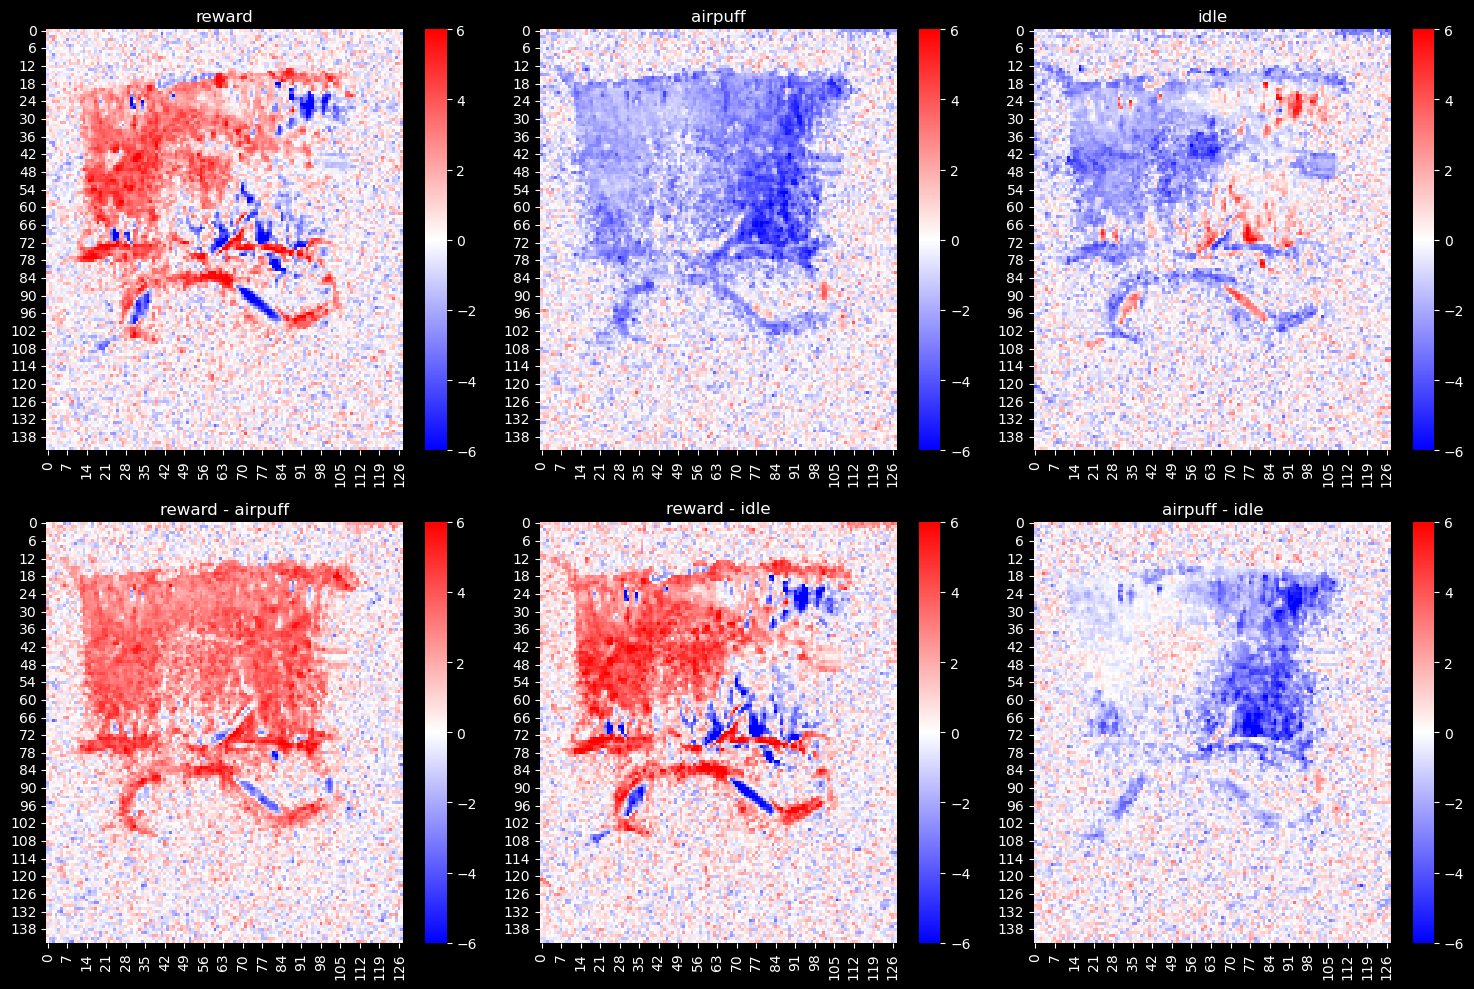

In [12]:
data_dir = '/Users/yibeichen/Desktop/fusi/task_data/Grouper_Audiocue_data/same_plane/Grouper_0606_1.5'
brain_filename = 'Grouper_audiocue_060624_fus2D.2Dscan_1_fus2D.source.nii'
event_filename = 'mldata.mat'

contrast_conditions = {
    'reward': '5',
    'airpuff': '6',
    'idle': '7',
    'reward - airpuff': np.array([1, -1, 0, 0, 0, 0, 0]),
    'reward - idle': np.array([1, 0, -1, 0, 0, 0, 0]),
    'airpuff - idle': np.array([0, 1, -1, 0, 0, 0, 0]),
}

run_glm_analysis(data_dir, brain_filename, event_filename, contrast_conditions, vmin=-6, vmax=6, before0523=False)
